## Seminar 2: Dealing with Word Embeddings

Today we gonna play with word embeddings: train our own little embedding, load one from   gensim model zoo and use it to visualize text corpora.

This whole thing is gonna happen on top of embedding dataset.

__Requirements:__  `pip install --upgrade nltk gensim bokeh umap-learn` , but only if you're running locally.

In [1]:
import itertools
import string

import numpy as np
import umap
from nltk.tokenize import WordPunctTokenizer

from matplotlib import pyplot as plt
plt.style.use('dark_background')

from IPython.display import clear_output

In [8]:
# download the data:
# !wget https://www.dropbox.com/s/obaitrix9jyu84r/quora.txt?dl=1 -O ./quora.txt -nc
# alternative download link: https://yadi.sk/i/BPQrUu1NaTduEw

In [4]:
data = list(open("quora.txt", encoding="utf-8"))
data[50]

"What TV shows or books help you read people's body language?\n"

__Tokenization:__ a typical first step for an nlp task is to split raw data into words.
The text we're working with is in raw format: with all the punctuation and smiles attached to some words, so a simple str.split won't do.

Let's use __`nltk`__ - a library that handles many nlp tasks like tokenization, stemming or part-of-speech tagging.

In [5]:
tokenizer = WordPunctTokenizer()
print(tokenizer.tokenize(data[50]))

['What', 'TV', 'shows', 'or', 'books', 'help', 'you', 'read', 'people', "'", 's', 'body', 'language', '?']


In [6]:
# TASK: lowercase everything and extract tokens with tokenizer. 
# data_tok should be a list of lists of tokens for each line in data.
data_tok =  [tokenizer.tokenize(item.lower()) for item in data] # YOUR CODE HEER

Let's peek at the result:

In [7]:
' '.join(data_tok[0])

"can i get back with my ex even though she is pregnant with another guy ' s baby ?"

Small check that everything is alright

In [8]:
assert all(isinstance(row, (list, tuple)) for row in data_tok), "please convert each line into a list of tokens (strings)"
assert all(all(isinstance(tok, str) for tok in row) for row in data_tok), "please convert each line into a list of tokens (strings)"
is_latin = lambda tok: all('a' <= x.lower() <= 'z' for x in tok)
assert all(map(lambda l: not is_latin(l) or l.islower(), map(' '.join, data_tok))), "please make sure to lowercase the data"

__Word vectors:__ as the saying goes, there's more than one way to train word embeddings. There's Word2Vec and GloVe with different objective functions. Then there's fasttext that uses character-level models to train word embeddings. 

The choice is huge, so let's start someplace small: __gensim__ is another NLP library that features many vector-based models incuding word2vec.

In [12]:
from gensim.models import Word2Vec

model = Word2Vec(data_tok, 
                 vector_size=32,      # embedding vector size
                 min_count=5,         # consider words that occured at least 5 times
                 window=5).wv  # define context as a 5-word window around the target word

In [13]:
# now you can get word vectors !
model.get_vector('anything').shape

(32,)

In [14]:
print(model.__dict__.keys())

dict_keys(['vector_size', 'index_to_key', 'next_index', 'key_to_index', 'vectors', 'norms', 'expandos', 'mapfile_path', 'vectors_lockf'])


In [15]:
# or query similar words directly. Go play with it!
model.most_similar('bread')

[('rice', 0.9422351717948914),
 ('sauce', 0.9316478371620178),
 ('fruit', 0.9245351552963257),
 ('pasta', 0.9235250353813171),
 ('cheese', 0.9183783531188965),
 ('butter', 0.9131743907928467),
 ('beans', 0.9086142778396606),
 ('chicken', 0.9029293656349182),
 ('wine', 0.902805745601654),
 ('soup', 0.897556483745575)]

### Using pre-trained model

Took it a while, huh? Now imagine training life-sized (100~300D) word embeddings on gigabytes of text: wikipedia articles or twitter posts. 

Thankfully, nowadays you can get a pre-trained word embedding model in 2 lines of code (no sms required, promise).

In [16]:
import gensim.downloader as api
model = api.load('glove-twitter-25')

In [26]:
model.most_similar(positive=["street"], negative=["brain"])

[('karnaval', 0.7423005700111389),
 ('rouen', 0.7211644053459167),
 ('newyork', 0.7105720639228821),
 ('nanterre', 0.710467517375946),
 ('seri', 0.7028310894966125),
 ('cannes', 0.7026445865631104),
 ('chtis', 0.6946518421173096),
 ('metz', 0.6918202638626099),
 ('genève', 0.6898825764656067),
 ('strasbourg', 0.6887412667274475)]

In [27]:
model.most_similar(positive=["bread"])

[('meat', 0.9616429209709167),
 ('corn', 0.961062490940094),
 ('cheese', 0.9532766342163086),
 ('noodles', 0.9493104219436646),
 ('soup', 0.9440536499023438),
 ('egg', 0.9418217539787292),
 ('milk', 0.9414371848106384),
 ('chicken', 0.9398934841156006),
 ('beans', 0.9390753507614136),
 ('toast', 0.936586856842041)]

In [34]:
model.get_vector('islam')

array([ 0.25199 , -0.71129 , -0.72056 , -0.64193 , -0.86795 , -0.49329 ,
        0.29254 ,  0.60849 ,  0.91141 ,  1.5407  , -0.82123 ,  0.57063 ,
       -2.3433  ,  0.70177 , -0.54684 ,  0.16365 , -0.50416 ,  0.15395 ,
       -0.08604 , -0.45299 ,  0.081592, -0.33397 , -2.9764  , -1.0516  ,
       -1.1241  ], dtype=float32)

In [28]:
model.most_similar(positive=["islam"])

[('muslim', 0.8808693885803223),
 ('dakwah', 0.8304200768470764),
 ('jihad', 0.8004356026649475),
 ('agama', 0.7914139628410339),
 ('kafir', 0.7834516167640686),
 ('umat', 0.7833907604217529),
 ('arab', 0.7787570953369141),
 ('ulama', 0.7749825119972229),
 ('haram', 0.7732717990875244),
 ('muslims', 0.7634982466697693)]

In [55]:
words = ['true', "country", 'what', 'a', 'you', 'is', 'the', "<user>", "cry", 'hello']
m = 10
for word in words:
    print(word,"_"*(m-len(word)), "_"*10, np.linalg.norm(model.get_vector(word)), "_"*5, 
          model.key_to_index[word])

true ______ __________ 5.179576 _____ 547
country ___ __________ 5.18777 _____ 1670
what ______ __________ 6.254182 _____ 86
a _________ __________ 6.697466 _____ 11
you _______ __________ 6.8969526 _____ 15
is ________ __________ 6.566807 _____ 32
the _______ __________ 6.8252115 _____ 13
<user> ____ __________ 4.7851086 _____ 0
cry _______ __________ 5.037864 _____ 999
hello _____ __________ 4.244391 _____ 996


### Visualizing word vectors

One way to see if our vectors are any good is to plot them. Thing is, those vectors are in 30D+ space and we humans are more used to 2-3D.

Luckily, we machine learners know about __dimensionality reduction__ methods.

Let's use that to plot 1000 most frequent words

In [29]:
len(model.key_to_index)  # insterad of vocab

1193514

In [56]:
words = sorted(model.key_to_index.items(), key=lambda item: item[1])[:1000]
print(words[::100])

[('<user>', 0), ('_', 100), ('please', 200), ('apa', 300), ('justin', 400), ('text', 500), ('hari', 600), ('playing', 700), ('once', 800), ('sei', 900)]


In [57]:
words[-10:]

[('relationship', 990),
 ('idk', 991),
 ('hurt', 992),
 ('st', 993),
 ('pernah', 994),
 ('pessoas', 995),
 ('hello', 996),
 ('uno', 997),
 ('unfollowers', 998),
 ('cry', 999)]

In [58]:
# for each word, compute it's vector with model

word_vectors = np.array([model.get_vector(word[0]) for word in words])#  YOUR CODE
len(word_vectors)

1000

In [59]:
assert isinstance(word_vectors, np.ndarray)
assert word_vectors.shape == (len(words), 25)
assert np.isfinite(word_vectors).all()

In [60]:
word_vectors.shape

(1000, 25)

#### Linear projection: PCA

The simplest linear dimensionality reduction method is __P__rincipial __C__omponent __A__nalysis.

In geometric terms, PCA tries to find axes along which most of the variance occurs. The "natural" axes, if you wish.

<img src="https://github.com/yandexdataschool/Practical_RL/raw/master/yet_another_week/_resource/pca_fish.png" style="width:30%">


Under the hood, it attempts to decompose object-feature matrix $X$ into two smaller matrices: $W$ and $\hat W$ minimizing _mean squared error_:

$$\|(X W) \hat{W} - X\|^2_2 \to_{W, \hat{W}} \min$$
- $X \in \mathbb{R}^{n \times m}$ - object matrix (**centered**);
- $W \in \mathbb{R}^{m \times d}$ - matrix of direct transformation;
- $\hat{W} \in \mathbb{R}^{d \times m}$ - matrix of reverse transformation;
- $n$ samples, $m$ original dimensions and $d$ target dimensions;



In [61]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
pca = PCA(2)
scaler = StandardScaler()
# map word vectors onto 2d plane with PCA. Use good old sklearn api (fit, transform)
# after that, normalize vectors to make sure they have zero mean and unit variance
word_vectors_pca = pca.fit_transform(word_vectors)# YOUR CODE
word_vectors_pca = scaler.fit_transform(word_vectors_pca)
# and maybe MORE OF YOUR CODE here :)

In [62]:
assert word_vectors_pca.shape == (len(word_vectors), 2), "there must be a 2d vector for each word"
assert max(abs(word_vectors_pca.mean(0))) < 1e-5, "points must be zero-centered"
assert max(abs(1.0 - word_vectors_pca.std(0))) < 1e-2, "points must have unit variance"

#### Let's draw it!

In [23]:
import bokeh.models as bm, bokeh.plotting as pl
from bokeh.io import output_notebook
output_notebook()

def draw_vectors(x, y, radius=10, alpha=0.25, color='blue',
                 width=600, height=400, show=True, **kwargs):
    """ draws an interactive plot for data points with auxilirary info on hover """
    if isinstance(color, str): color = [color] * len(x)
    data_source = bm.ColumnDataSource({ 'x' : x, 'y' : y, 'color': color, **kwargs })

    fig = pl.figure(active_scroll='wheel_zoom', width=width, height=height)
    fig.scatter('x', 'y', size=radius, color='color', alpha=alpha, source=data_source)

    fig.add_tools(bm.HoverTool(tooltips=[(key, "@" + key) for key in kwargs.keys()]))
    if show: pl.show(fig)
    return fig

Loading BokehJS ...

In [91]:
draw_vectors(word_vectors_pca[:, 0], word_vectors_pca[:, 1], token=words)

# hover a mouse over there and see if you can identify the clusters

Figure(id='1004', ...)

### Visualizing neighbors with UMAP
PCA is nice but it's strictly linear and thus only able to capture coarse high-level structure of the data.

If we instead want to focus on keeping neighboring points near, we could use UMAP, which is itself an embedding method. Here you can read __[more on UMAP (ru)](https://habr.com/ru/company/newprolab/blog/350584/)__ and on __[t-SNE](https://distill.pub/2016/misread-tsne/)__, which is also an embedding.

In [2]:
import umap.umap_ as umap

In [25]:
embedding = umap.UMAP(n_neighbors=5).fit_transform(word_vectors) # преобразовываем

In [26]:
draw_vectors(embedding[:, 0], embedding[:, 1], token=words)

# hover a mouse over there and see if you can identify the clusters

Figure(id='1004', ...)

### Visualizing phrases

Word embeddings can also be used to represent short phrases. The simplest way is to take __an average__ of vectors for all tokens in the phrase with some weights.

This trick is useful to identify what data are you working with: find if there are any outliers, clusters or other artefacts.

Let's try this new hammer on our data!


In [63]:
def get_phrase_embedding(phrase):
    """
    Convert phrase to a vector by aggregating it's word embeddings. See description above.
    """
    # 1. lowercase phrase
    # 2. tokenize phrase
    # 3. average word vectors for all words in tokenized phrase
    # skip words that are not in model's vocabulary
    # if all words are missing from vocabulary, return zeros
    
    vector = np.zeros([model.vector_size], dtype='float32')
    phrase_tokenized = tokenizer.tokenize(phrase.lower())
    phrase_vectors = [model[x] for x in phrase_tokenized if x in model.index_to_key]

    if len(phrase_vectors) != 0:
        vector = np.mean(phrase_vectors, axis=0)

    # YOUR CODE
    
    return vector
        
    

In [64]:
data[402687]

'What gift should I give to my girlfriend on her birthday?\n'

In [65]:
get_phrase_embedding(data[402687])

array([-0.18204999,  0.30953574,  0.20861094,  0.07982156, -0.22565515,
       -0.33001748,  1.2495784 ,  0.13134292, -0.33788875,  0.06196944,
       -0.231793  ,  0.09389219, -4.9685497 , -0.23611419, -0.32609668,
       -0.092073  ,  0.4407505 , -0.75413746, -0.5389092 , -0.184752  ,
        0.07867809,  0.20018655, -0.16202375,  0.30375698, -0.41255665],
      dtype=float32)

In [66]:
vector = get_phrase_embedding("I'm very sure. This never happened to me before...")
vector

array([ 0.1663555 ,  0.0534049 ,  0.01988658, -0.14495362, -0.48189807,
        0.0201319 ,  1.1701978 ,  0.39422765, -0.5707375 ,  0.07880499,
       -0.34534982, -0.0293695 , -4.785525  ,  0.04907916, -0.08470917,
        0.1303215 ,  0.03921234, -0.18863894, -0.60683554, -0.4688374 ,
        0.12880965,  0.01707016,  0.16700326,  0.4306834 , -0.05759042],
      dtype=float32)

In [67]:
# let's only consider ~5k phrases for a first run.
chosen_phrases = data[::len(data) // 1500]

# compute vectors for chosen phrases and turn them to numpy array
phrase_vectors = np.asarray([get_phrase_embedding(x) for x in chosen_phrases]) # YOUR CODE

In [68]:
print(len(chosen_phrases))
print(phrase_vectors.shape)

1501
(1501, 25)


In [48]:
assert isinstance(phrase_vectors, np.ndarray) and np.isfinite(phrase_vectors).all()
assert phrase_vectors.shape == (len(chosen_phrases), model.vector_size)

In [49]:
# map vectors into 2d space with pca, tsne or your other method of choice
# don't forget to normalize

phrase_vectors_2d = umap.UMAP(n_neighbors=3).fit_transform(phrase_vectors) # преобразовываем

# phrase_vectors_2d = (phrase_vectors_2d - phrase_vectors_2d.mean(axis=0)) / phrase_vectors_2d.std(axis=0)

In [50]:
draw_vectors(phrase_vectors_2d[:, 0], phrase_vectors_2d[:, 1],
             phrase=[phrase[:50] for phrase in chosen_phrases],
             radius=20,)

Figure(id='1364', ...)

Finally, let's build a simple "similar question" engine with phrase embeddings we've built.

In [69]:
%%time
# compute vector embedding for all lines in data
data_vectors = np.vstack([get_phrase_embedding(l) for l in data[::50]])

Wall time: 1min 56s


In [70]:
data_vectors.shape

(10746, 25)

In [71]:
norms = np.linalg.norm(data_vectors, axis=1)
norms.shape

(10746,)

In [72]:
printable_set = set(string.printable)

In [73]:
data_subset = [x for x in data if set(x).issubset(printable_set)]
len(data_subset)

531050

In [74]:
def find_nearest(query, k=10):
    """
    given text line (query), return k most similar lines from data, sorted from most to least similar
    similarity should be measured as cosine between query and line embedding vectors
    hint: it's okay to use global variables: data and data_vectors. see also: np.argpartition, np.argsort
    """
    # YOUR CODE
    query_vector = get_phrase_embedding(query)
    dists = data_vectors.dot(query_vector[:, None])[:, 0] / ((norms+1e-16)*np.linalg.norm(query_vector))
    nearest_elements = dists.argsort(axis=0)[-k:][::-1]
    out = [data[i] for i in nearest_elements]
    return out# <YOUR CODE: top-k lines starting from most similar>

In [75]:
results = find_nearest(query="How do i enter the matrix?", k=10)

print(''.join(results))

assert len(results) == 10 and isinstance(results[0], str)
# assert results[0] == 'How do I get to the dark web?\n'
# assert results[3] == 'What can I do to save the world?\n'

How do I start a food truck in Mumbai?
What is the meaning of the French phrase "Je t'adore"? How is it used in conversation?
I got AIR 29 in the BTech exam at Cluster Innovation Centre. Is there any chance that I get selected? What are the previous years' closing ranks?
Describe the village of sonning?
How many customers shop target each day?
How do I use PLR articles?
Is Windows the only OS that is not based on UNIX or Linux?
I want to pursue a master's in computer science at a university at the same level as Stanford. I am studying ECE at Thapar. What should I do in the remaining 3 years of my Btech?
What do the grade shares mean?
Can you get a divorce without a lawyer? If so, how?



In [76]:
find_nearest(query="How does Trump?", k=10)

["If there's only one true God why are there so many different religions and why are they similar?\n",
 'What are the streams in mechanical engineering i can pursue for M.Tech or M.S after my graduation ?\n',
 'If you knew you were going to die, would you choose hospice care, and why?\n',
 'What can an Indian citizen do today that would most contribute to improve the lives of his or her countrymen?\n',
 'Do you think more with the subconcious when you are tired and more with the conscious when you feel good?\n',
 'Why are some sports such as tennis and golf have "Open" in a tournament name? E.g. U.S. Open\n',
 'What proof is there that the earth is not flat?\n',
 'How much does it cost to travel Sri Lanka from India?\n',
 'What are the best and profitable ways for saving money?\n',
 'Left 3yr relationship w father of 1yr old due to his unrequited love for me. So, why am I blaming myself?\n']

In [77]:
find_nearest(query="Why don't i ask a question myself?", k=10)

["What is it that makes you catch a cold when you get caught in the rain, if it is essentially the same thing as being drenched in water when you're showering?\n",
 'Call Centers: What is the best way to get campaigns for my call center?\n',
 'What is Business Protection Insurance?\n',
 'I asked a girl out for a coffee, she said yes but ill let you know, what does that mean?\n',
 'Renaissance Technologies: How can I invest with your fund and where can I see your past performance?\n',
 'Can we convert a virtual machine to a docker image?\n',
 'How do I disable notification in Quora?\n',
 'What is the compensation package for a new grad software engineer starting at Evernote in 2014?\n',
 'What kinds of mythical creatures are there? What are they known for and what are their symbols?\n',
 'Can I use my mic jack as an audio jack on my headphones?\n']

In [78]:
from sklearn.cluster import DBSCAN, KMeans

In [70]:
kmeans = KMeans(3)

In [73]:
labels = kmeans.fit_predict(np.asarray(phrase_vectors))
_colors = ['red', 'green', 'blue']

In [74]:
draw_vectors(phrase_vectors_2d[:, 0], phrase_vectors_2d[:, 1], color=[_colors[l] for l in labels],
             phrase = [phrase[:50] for phrase in chosen_phrases], radius = 20)

Figure(id='1506', ...)

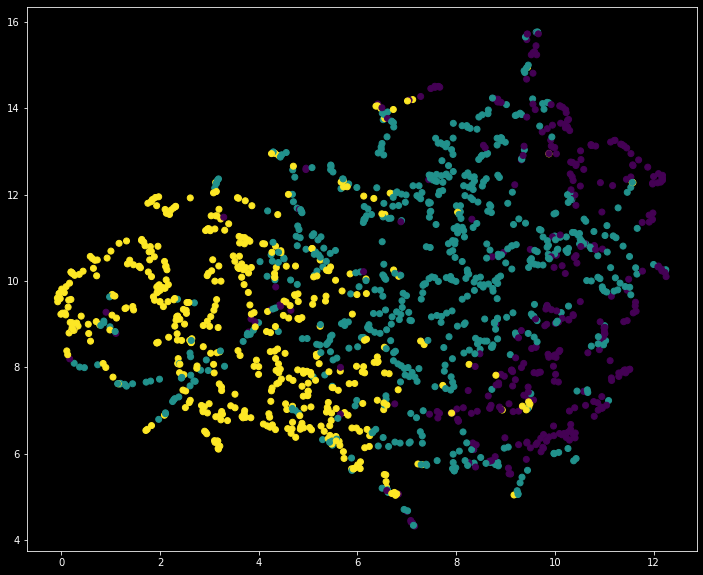

In [72]:
plt.figure(figsize=(12, 10))
plt.scatter(phrase_vectors_2d[:,0], phrase_vectors_2d[:, 1], c=labels.astype(float))

__Now what?__
* Try running TSNE instead of UMAP (it takes a long time)
* Try running UMAP or TSNEon all data, not just 1000 phrases
* See what other embeddings are there in the model zoo: `gensim.downloader.info()`
* Take a look at [FastText](https://github.com/facebookresearch/fastText) embeddings
* Optimize find_nearest with locality-sensitive hashing: use [nearpy](https://github.com/pixelogik/NearPy) or `sklearn.neighbors`.




### Extra: your own word2vec

In [3]:
import torch
import torch.nn as  nn
import torch.autograd  as autograd
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

In [ ]:
vocabulary = set(itertools.chain.from_iterable(data_tok))

word_to_index = # YOUR CODE HERE
index_to_word = # YOUR CODE HERE
word_counter = {word: 0 for word in word_to_index.keys()}

Generating context pairs:

In [ ]:
context_tuple_list = []
w = 4

for text in data_tok:
    for i, word in enumerate(text):
        first_context_word_index = max(0,i-w)
        last_context_word_index = min(i+w, len(text))
        for j in range(first_context_word_index, last_context_word_index):
            if i!=j:
                context_tuple_list.append((word_to_index[word], word_to_index[text[j]]))
                word_counter[word] += 1.
print("There are {} pairs of target and context words".format(len(context_tuple_list)))

Casting everything to `torch.LongTensor`

In [ ]:
data_torch = torch.tensor(context_tuple_list).type(torch.LongTensor)
X_torch = data_torch[:, 0]
y_torch = data_torch[:, 1]
del data_torch

In [ ]:
class Word2VecModel(nn.Module):

    def __init__(self, embedding_size, vocab_size):
        super(Word2VecModel, self).__init__()
        # YOUR CODE HERE
        
    def forward(self, context_word):
        # YOUR CODE HERE

In [ ]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
model = Word2VecModel(25, len(word_to_index)).to(device)

In [ ]:
loss_func = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=0.01)
# To reduce learning rate on plateau of the loss functions
lr_scheduler = ReduceLROnPlateau(opt, patience=35)

In [ ]:
loss_func(model(X_torch[:5].to(device)), y_torch[:5].to(device))

In [ ]:
batch_size = 1024
n_iterations = 1000
local_train_loss_history = []

In [ ]:
def plot_train_process(train_loss):
    fig, axes = plt.subplots(1, 1, figsize=(15, 5))

    axes.set_title('Loss')
    axes.plot(train_loss, label='train')
    axes.legend()
    plt.show()

In [ ]:
for i in range(n_iterations):

    ix = np.random.randint(0, len(context_tuple_list), batch_size)
    x_batch = X_torch[ix].to(device)
    y_batch = y_torch[ix].to(device)

    # predict log-probabilities or logits
    ### YOUR CODE

    # compute loss, just like before
    ### YOUR CODE


    # compute gradients
    ### YOUR CODE

    # Adam step
    ### YOUR CODE

    # clear gradients
    ### YOUR CODE

    local_train_loss_history.append(loss.item())
    lr_scheduler.step(local_train_loss_history[-1])
    
    if i % 100 == 0:
        clear_output(True)
        plot_train_process(local_train_loss_history)

In [ ]:
matrix = next(model.embeddings.parameters()).detach().cpu()

In [ ]:
def get_closest(word, top_n):
    global matrix, word_to_index, index_to_word
    y = matrix[word_to_index[word]][None, :]

    dist = F.cosine_similarity(matrix,y)
    index_sorted = torch.argsort(dist)
    top_n = index_sorted[-top_n:]
    return [index_to_word[x] for x in top_n.numpy()]

In [ ]:
get_closest('apple', 5)

It might look not so promising. Remember about the upgrades to word2vec: subsampling and negative sampling.